In [1]:
!pip install datasets transformers accelerate keras tensorflow umap -q

In [2]:
from datasets import list_datasets

all_datasets=list_datasets()

print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are : {all_datasets[:10]}")

<ipython-input-2-6ed87c2cd49b>:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets=list_datasets()


There are 59417 datasets currently available on the Hub
The first 10 are : ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [3]:
from datasets import load_dataset

emotions=load_dataset('emotion')

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds=emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
len(train_ds)

16000

In [7]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [8]:
train_ds.column_names

['text', 'label']

In [9]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [10]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [11]:
print(train_ds['text'][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


In [12]:
dataset_url="http://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"

!wget dataset_url

--2023-08-31 01:43:52--  http://dataset_url/
Resolving dataset_url (dataset_url)... failed: Name or service not known.
wget: unable to resolve host address ‘dataset_url’


In [13]:
# emotions_remote=load_dataset('csv',data_files=dataset_url,sep=';',names=['text','label'])

In [14]:
import pandas as pd

emotions.set_format(type='pandas')


In [15]:
df=emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [16]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name']=df['label'].apply(label_int2str)

df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


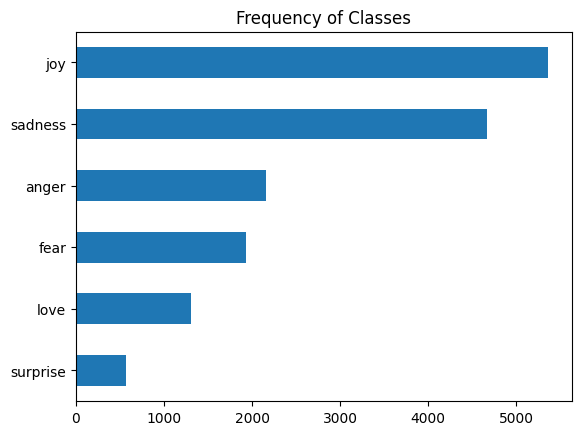

In [17]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

# To DEAL with Imbalance
- Randomly oversample the minority clas
- Randomly undersample the majority class
- Gether more labeled data from the underrepresented classes

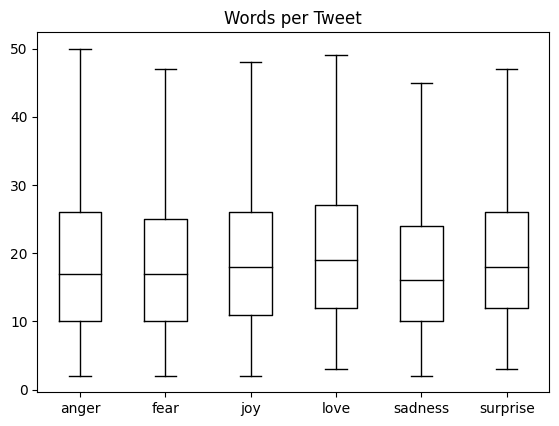

In [18]:
df['Words per Tweet']=df['text'].str.split().apply(len)
df.boxplot('Words per Tweet', by='label_name',grid=False,showfliers=False,color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

In [19]:
emotions.reset_format()

# Character Tokenization

In [20]:
text='Tokenizing text is a core task of NLP'
tokenized_text=list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P']


In [21]:
# Our model expect each character to be converted to an integer, a process sometimes called numericalization.
# One simple way of doing this is by encoding each unique token with a unique integer

In [22]:
token2idx={ch:idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, 'L': 1, 'N': 2, 'P': 3, 'T': 4, 'a': 5, 'c': 6, 'e': 7, 'f': 8, 'g': 9, 'i': 10, 'k': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'x': 17, 'z': 18}


In [23]:
input_ids=[token2idx[token] for token in tokenized_text]
print(input_ids)

[4, 13, 11, 7, 12, 10, 18, 10, 12, 9, 0, 16, 7, 17, 16, 0, 10, 15, 0, 5, 0, 6, 13, 14, 7, 0, 16, 5, 15, 11, 0, 13, 8, 0, 2, 1, 3]


In [24]:
categorical_df=pd.DataFrame({"Name":['Bumblebee','Optimus Prime',"Megatron"],"Label ID":[0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


# Problem here is that this approach creates a fictitious ordering between names, and neural networks are really good at leearning these kinds of relationships. So instead we can create a new column for each category and assing a 1 where the categgory is true and 0 otherwise

In [25]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [26]:
import torch
import torch.nn.functional as F

input_ids=torch.tensor(input_ids)
one_hot_encodings=F.one_hot(input_ids,num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([37, 19])

In [27]:
# First Vector, we can very that a 1 appears in the location indicated by input_ids[0]:

print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 4
One-hot: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


**Character-level tokenization ignores tany structure in the text and treats the whole string as a stream of characters. Although this helps deal with misspellings and rare words, the main drawback is that linguistic structures such as words need to be learned from the data.This requires significatn compute,memory and data. For this reason, character tokenization is rarely used in practice. instead, some structure of the text is preserved during the tokenziation step. Word tokenization is a straightforward approach to achieve this**

In [28]:
tokenized_text=text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP']


# One potential promlem with this tokenization scheme: punctuation is not accounrted for, so NLP

# Having a large vocabulary is a problem becasue it requires neural networks to have an enormous number of parameters.
- To illsutrate this, suppose we have 1 Million unique words and want to compress the 1 million-dimensional input vectors to 1-thousand dimensional vectors in the first layer of our network.
- Resulting weight matrix of this firt layer would contain 1 million x 1 thousands= 1 billion weights.
- To limit the vocabulary and discard rare words by considering, say, the 100K most common words in the corpus
 - words that are not part fof the vocabulary are classified as "unknown" and mapped to a shared UNK token
   - This means we lose tom potentailly important information in the process of word tokenization, since the model has no infromation about wrods associated with UNK

# To solve this : Subword Tokenization
- Combine the bet aspects of caharacter and word tokenization
  - On the one hand, we wqant to split rare wrods into smaller units to allow the model to deal with complex words and misspellings
  - On the other hand, we want to keep frequent words as unique entities so that we can kleep the length of our inputs to a manageable size.
- The main distinguishing feature of subword tokenization is that it is learned from the pretraining corpus using a mix of statistical rules and algorithms

**subword tokenization algorithms:**
- WordsPiece


In [29]:
from transformers import AutoTokenizer

model_ckpt="distilbert-base-uncased"
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

## Automatically retrieve the models configuratiion, pretrained weights, or vocabulary from the name of the checkpoint.

In [30]:
#Manually laoding models

from transformers import DistilBertTokenizer

distilbert_tokenizer=DistilBertTokenizer.from_pretrained(model_ckpt)

In [31]:
encoded_text=tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [32]:
tokens=tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']


In [33]:
print(tokenizer.convert_tokens_to_string(tokens))


[CLS] tokenizing text is a core task of nlp [SEP]


In [34]:
tokenizer.vocab_size

30522

In [35]:
tokenizer.model_max_length

512

In [36]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [37]:
# Tokenizing the Whole Dataset

def tokenize(batch):
    return tokenizer(batch['text'],padding=True,truncation=True)


In [38]:
print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [39]:
emotions_encoded=emotions.map(tokenize,batched=True,batch_size=None)
## map() methods operates individually on every example in the corpus, so setting batched=True will encode the tweets in batches.
## Because we set the batch_size=None, our tokenize() function willbe applied on the full datasetas a single batch
## This ensures that the input tensors and attention masks have the same shape globally.

In [40]:
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [41]:
from transformers import AutoModel

model_ckpt="distilbert-base-uncased"
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model= AutoModel.from_pretrained(model_ckpt).to(device)

In [42]:
# Tensorflow

from transformers import TFAutoModel

tf_model=TFAutoModel.from_pretrained(model_ckpt)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [43]:
tf_xlmr=TFAutoModel.from_pretrained('xlm-roberta-base')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [44]:
tf_xlmr=TFAutoModel.from_pretrained('xlm-roberta-base',from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [45]:
text='this is a test'
inputs=tokenizer(text,return_tensors='pt')
print(f"Input tensor shape:{inputs['input_ids'].size()}")

Input tensor shape:torch.Size([1, 6])


In [46]:
inputs={k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs=model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [47]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [48]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [49]:
def extract_hidden_states(batch):
    inputs={k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad():
        last_hidden_state=model(**inputs).last_hidden_state
    #Return vector for [CLS] token
    return {"hidden_state":last_hidden_state[:,0].cpu().numpy()}

In [50]:
emotions_encoded.set_format("torch",columns=['input_ids','attention_mask',"label"])

In [51]:
emotions_hidden=emotions_encoded.map(extract_hidden_states,batched=True)


In [52]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

#Creating a Feature Matrix

In [53]:
import numpy as np

X_train=np.array(emotions_hidden['train']['hidden_state'])
X_valid=np.array(emotions_hidden['validation']['hidden_state'])
y_train=np.array(emotions_hidden['train']['label'])
y_valid=np.array(emotions_hidden['validation']['label'])

X_train.shape,X_valid.shape

((16000, 768), (2000, 768))

In [54]:
!pip uninstall umap -q
!pip install umap-learn -q


Proceed (Y/n)? y


In [55]:
import umap.umap_ as UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled=MinMaxScaler().fit_transform(X_train)
mapper=UMAP(n_components=2,metric='cosine').fit(X_scaled)

df_emb=pd.DataFrame(mapper.embedding_,columns=['X','Y'])

df_emb['label']=y_train
df_emb.head()


TypeError: ignored

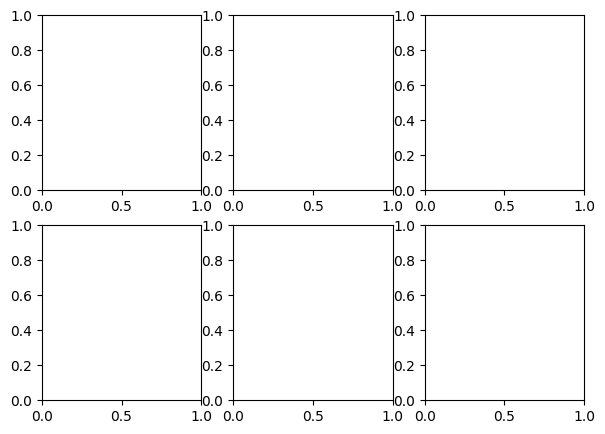

In [59]:
fig, axes=plt.subplots(2,3,figsize=(7,5))
axes=axes.flatten()
cmaps=['Greys','Blues','Oranges','Reds','Purples','Greens']
labels=emotions['train'].features['label'].names

# for i,(label,cmap) in enumerate(zip(labels,cmaps)):
#     df_emb_sub=df_emb.query(f'label=={i}')
#     axes[i].hexbin(def_emb_sub['X'],df_emb_sub['Y'],cmap=cmap,gridsize=20,linewidths=(0,))
#     axes[i].set_title(label)
#     axes[i].set_xticks([]),axes[i].set_yticks([])

# plt.tight_layout()
# plt.show()



In [60]:
from sklearn.linear_model import LogisticRegression

## we increase 'max_iter' to guarantee convergence

lr_clf=LogisticRegression(max_iter=3000)
lr_clf.fit(X_train,y_train)
lr_clf.score(X_valid,y_valid)

0.633

In [61]:
from sklearn.dummy import DummyClassifier

dummy_clf=DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train,y_train)
dummy_clf.score(X_valid,y_valid)

0.352

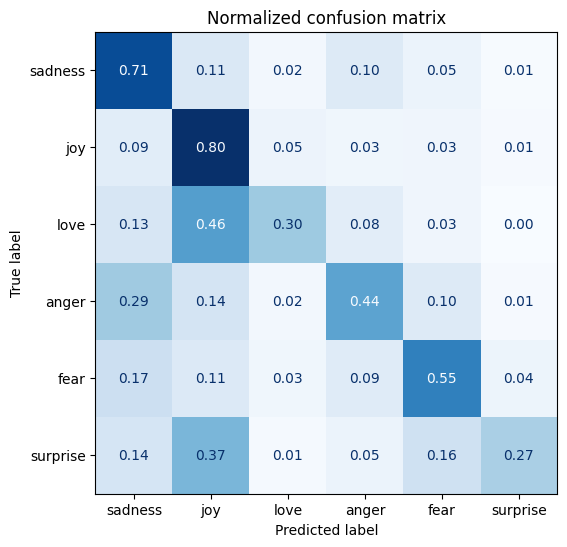

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds,y_true,labels):
    cm=confusion_matrix(y_true,y_preds,normalize='true')
    fig,ax=plt.subplots(figsize=(6,6))
    disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
    disp.plot(cmap='Blues',values_format='.2f',ax=ax,colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds=lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds,y_valid,labels)

In [63]:
from transformers import AutoModelForSequenceClassification

num_labels=6
model=(AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
from sklearn.metrics import accuracy_score,f1_score

def compute_metrics(pred):
    labels=pred.label_ids
    preds=pred.predictions.argmax(-1)
    f1=f1_score(labels,preds,average='weighted')
    acc=accuracy_score(labels,preds)
    return{'accuracy':acc,'f1':f1}

In [65]:
from huggingface_hub import notebook_login

notebook_login()

In [67]:
from transformers import TrainingArguments,Trainer
batch_size=64
logging_steps=len(emotions_encoded['train'])//batch_size
model_name=f'{model_ckpt}-finetuned-emotion'
training_args=TrainingArguments(
     output_dir=model_name
    ,num_train_epochs=2
    ,learning_rate=2e-5
    ,per_device_train_batch_size=batch_size
    ,per_device_eval_batch_size=batch_size
    ,weight_decay=0.01
    ,evaluation_strategy='epoch'
    ,disable_tqdm=False
    ,logging_steps=logging_steps
    ,push_to_hub=True
    ,log_level='error'
                                )

In [70]:
trainer=Trainer(
     model=model
    ,args=training_args
    ,compute_metrics=compute_metrics
    ,train_dataset=emotions_encoded['train']
    ,eval_dataset=emotions_encoded['validation']
    ,tokenizer=tokenizer
    )
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.826900,0.322471,0.906000,0.904601
2,0.254600,0.223243,0.922500,0.921946


TrainOutput(global_step=500, training_loss=0.5407512893676758, metrics={'train_runtime': 1276.6855, 'train_samples_per_second': 25.065, 'train_steps_per_second': 0.392, 'total_flos': 720342861696000.0, 'train_loss': 0.5407512893676758, 'epoch': 2.0})

In [71]:
preds_output=trainer.predict(emotions_encoded['validation'])

preds_output.metrics

{'test_loss': 0.2232428789138794,
 'test_accuracy': 0.9225,
 'test_f1': 0.9219461308150362,
 'test_runtime': 13.9519,
 'test_samples_per_second': 143.349,
 'test_steps_per_second': 2.294}

In [77]:
y_preds=np.argmax(preds_output.predictions,axis=1)



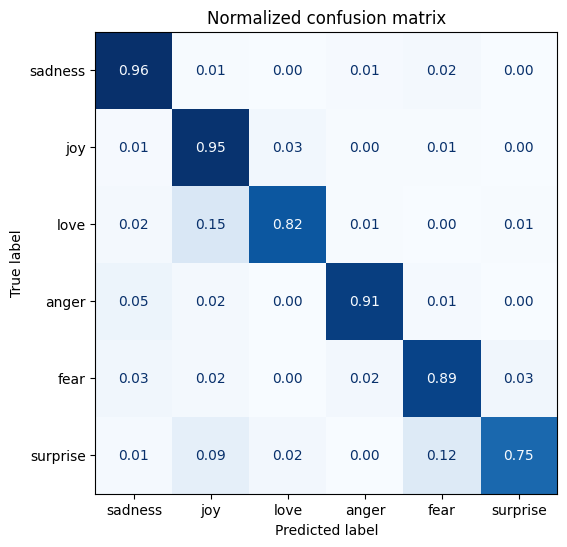

In [79]:
plot_confusion_matrix(y_preds,y_valid,labels)

In [73]:
# # USING KERAS

# from transformers import TFAutoModelForAudioClassification
# tf_model=(TFAutoModelForAudioClassification.from_pretrained(model_ckpt,num_labels=num_labels))

ValueError: ignored

In [ ]:
# tokenizer_columns=tokenizer.model_input_names

# tf_train_dataset=emotions_encoded['train'].to_tf_dataset(
#      columns=tokenizer_columns
#     ,labels_cols=['label']
#     ,shuffle=True
#     ,batch_size=batch_size
#      )

# tf_eval_dataset=emotions_encoded['validation'].to_tf_dataset(
#      columns=tokenizer_columns
#     ,labels_cols=['label']
#     ,shuffle=False
#     ,batch_size=batch_size
#      )

In [ ]:
# import tensorflow as tf

# tf_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5)
#     ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#     ,metrics=tf.metrics.SparseCategoricalAccuracy()
#     )
# tf_model.fit(tf_train_dataset,validation_data=tf_eval_dataset,epochs=2)

In [74]:
from torch.nn.functional import cross_entropy

def forward_pass_with_labels(batch):
    inputs={k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad():
        output=model(**inputs)
        pred_label=torch.argmax(output.logits,axis=-1)
        loss=cross_entropy(output.logits,batch['label'].to(device),reduction='none')

    return {"loss":loss.cpu().numpy(),
            'predicted_label':pred_label.cpu().numpy()}




In [76]:
emotions_encoded.set_format('torch',columns=['input_ids','attention_mask','label'])

emotions_encoded['validation']=emotions_encoded['validation'].map(forward_pass_with_labels,batched=True,batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [80]:
emotions_encoded.set_format('pandas')
cols=['text','label','predicted_label','loss']
df_test=emotions_encoded['validation'][:][cols]
df_test['label']=df_test['label'].apply(label_int2str)

df_test['predicted_label']=(df_test['predicted_label'].apply(label_int2str))

In [81]:
df_test.sort_values('loss',ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,5.669163
1801,i feel that he was being overshadowed by the s...,love,sadness,5.409098
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.211165
1274,i am going to several holiday parties and i ca...,joy,sadness,5.136889
1950,i as representative of everything thats wrong ...,surprise,sadness,5.108907
465,i would eventually go in to these stores but i...,joy,fear,5.038344
1963,i called myself pro life and voted for perry w...,joy,sadness,4.963983
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.908549
1683,i had applied for a job and they had assured m...,anger,joy,4.895780
1509,i guess this is a memoir so it feels like that...,joy,fear,4.856592


In [82]:
df_test.sort_values('loss',ascending=True).head(10)

,text,label,predicted_label,loss
69,i have no extra money im worried all of the ti...,sadness,sadness,0.017611
19,i had lunch with an old friend and it was nice...,joy,joy,0.017749
783,i feel like i deserve to be broke with how fri...,sadness,sadness,0.017905
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.017976
604,i don t like to use the h word recklessly but ...,joy,joy,0.017981
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.017987
121,i love for my girls to have an imagination and...,joy,joy,0.018006
31,i feel so damaged i just want you to have care...,sadness,sadness,0.018065
1656,im feeling very jaded and uncertain about love...,sadness,sadness,0.018114
244,im kinda relieve but at the same time i feel d...,sadness,sadness,0.018120


In [83]:
trainer.push_to_hub(commit_message='Training completed')

'https://huggingface.co/ckandemir/distilbert-base-uncased-finetuned-emotion/tree/main/'

In [84]:
from transformers import pipeline

model_id="ckandemir/distilbert-base-uncased-finetuned-emotion"
classifier=pipeline('text-classification',model=model_id)

In [85]:
custom_tweet='I saw a movie today and it was really good'
preds=classifier(custom_tweet,return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


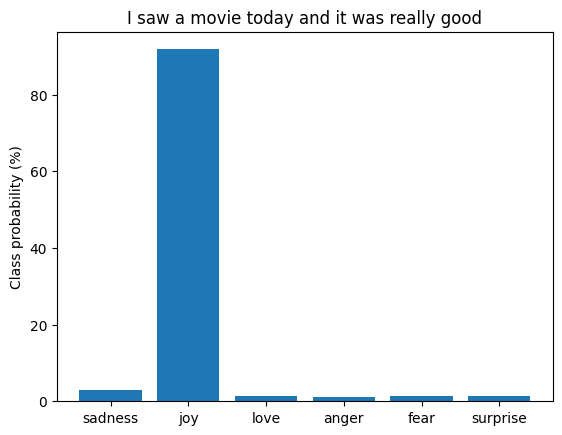

In [86]:
preds_df=pd.DataFrame(preds[0])
plt.bar(labels,100*preds_df['score'],color='C0')
plt.title(f'{custom_tweet}')
plt.ylabel("Class probability (%)")
plt.show()